In [1]:
import os
import sys

sys.path.append(os.getcwd() + '/')

In [2]:
import tifffile.tifffile as tiff
from matplotlib import pyplot as plt

no_bias = tiff.imread('temp/no_bias.tiff')
far_bias = tiff.imread('temp/far_bias.tiff')
counter_bias = tiff.imread('temp/counter_bias.tiff') / 255

In [3]:
import numpy as np
from torchvision.transforms import transforms
from utils.customTransforms import ToFloatUKBB

t = transforms.Compose([ToFloatUKBB(),transforms.ToTensor(), transforms.CenterCrop(180)])

no_bias = np.array(t(no_bias)).squeeze()
far_bias = np.array(t(far_bias)).squeeze()

Text(0.5, 1.0, 'Counter - Far')

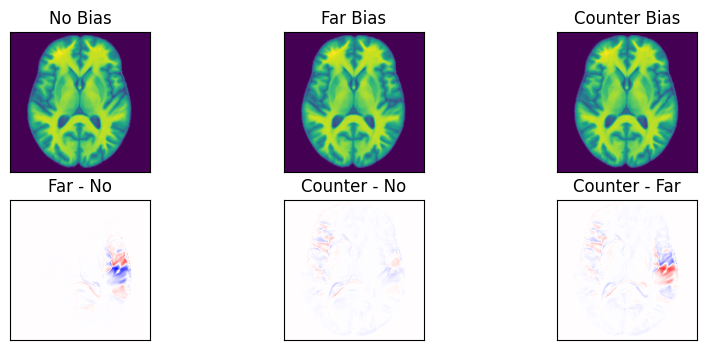

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(10, 4))
[a.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) for ax in axs for a in ax]

axs[0, 0].imshow(no_bias)
axs[0, 0].set_title("No Bias")

axs[0, 1].imshow(far_bias)
axs[0, 1].set_title("Far Bias")

axs[0, 2].imshow(counter_bias)
axs[0, 2].set_title("Counter Bias")

axs[1, 0].imshow(far_bias - no_bias,cmap ='seismic', clim=(-1, 1))
axs[1, 0].set_title("Far - No")

axs[1, 1].imshow(counter_bias - no_bias,cmap ='seismic', clim=(-1, 1))
axs[1, 1].set_title("Counter - No")

axs[1, 2].imshow(counter_bias - far_bias,cmap ='seismic', clim=(-1, 1))
axs[1, 2].set_title("Counter - Far")

In [15]:
far_no = (far_bias - no_bias).flatten()
counter_no = (counter_bias - no_bias).flatten()
counter_far = (counter_bias - far_bias).flatten()

far_no_mag = np.linalg.norm(far_no)
counter_no_mag = np.linalg.norm(counter_no)

In [25]:
projection = far_no.dot(counter_no)/far_no_mag
bias_removal = projection/far_no_mag
bias_removal

0.15105332094377252

In [29]:
bias_amplification = np.sqrt(counter_no_mag**2 - projection**2)
bias_amplification

2.2397666029469177